In [ ]:
!pip install transformers
!pip install rouge
!pip install tqdm
!pip install spacy==2.3.1
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.3.1/en_core_web_md-2.3.1.tar.gz

     |████████████████████████████████| 50.8MB 102kB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-cp37-none-any.whl size=50916642 sha256=81ae29d4f2f66ca7965209962fbd11ea72dbd69231996b9640fbf5c0e69dd919
  Stored in directory: /root/.cache/pip/wheels/6e/65/3a/34cdc26d4084d1d1f1e2ec9914964759ea17aa382c53a57d9f
Successfully built en-core-web-md


Imports

In [ ]:
import en_core_web_md
import numpy as np
import pandas as pd
import spacy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
import os

In [ ]:
from bs4 import BeautifulSoup as bs
from rouge import Rouge
import seaborn as sns
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import drive
import pprint
import time
pp = pprint.PrettyPrinter(indent=14)

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Création du dataset

In [301]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


On récupère toutes les phrases des rapports légaux complets, que l'on traite avec BeautifulSoup. On retire tous les caractères inutiles et spécifiques au format.xml. On fait de même avec les catchphrases, censés être le standard pour la validation de nos résumés. 

In [305]:
#Create the dataset 



path = 'data'

texts_sentences = []
texts_catchphrases = []

for id in os.listdir(path):
  sentences = []
  catchphrases = []
  try:
    with open(path +'/' + id, 'r') as f : 
      content = f.readlines()
      content = "".join(content)
      bs_content = bs(content,"lxml") #use beautifulsoup to read xml files
    for sentence in bs_content.find_all('sentence'):
      sentence = sentence.getText()
      sentence = sentence.replace('\n', '')
      sentences.append(sentence)
    texts_sentences.append(sentences)

    for catchphrase in bs_content.find_all('catchphrase'):
      catchphrase = catchphrase.getText()
      catchphrase = catchphrase.replace('\n', '')
      catchphrases.append(catchphrase)
    texts_catchphrases.append(catchphrases) 
  except : 
    print("erreur")
    

erreur
erreur


 **Exploration des données**


On affiche un texte entier. Il est très long, et est loin d'être parfait malgré le preprocessing. Il reste encore quelques chiffres et caractères spéciaux. 



In [ ]:
'. '.join(texts_sentences[42])

' INTRODUCTION  1 Virgin Blue Airlines Pty Ltd (\'Virgin\') has implemented certain criteria for passengers wishing to fly on its aircraft, the Independent Travel Criteria (\'the ITC\').. The ITC require that passengers are able to carry out certain actions independently.. By way of example, a passenger is required to be able to reach for, pull down and secure the overhead oxygen mask if needed.. If a passenger cannot carry out the specified actions, Virgin requires him or her to travel with a carer, another person who can assist the passenger to comply with the ITC.. Mr Corcoran and Mr Ferguson (together, \'the applicants\') each claim that they are unable to comply with the ITC and have commenced proceedings claiming that, in implementing and applying the ITC, Virgin has discriminated against them, directly and indirectly, under the Disability Discrimination Act 1992 (Cth) (\'the Act\').. 2 Both of the applicants are legally aided.. Each grant of legal aid provides for the payment of

Voici maintenant l'ensemble des catchphrases censées le résumer. Il s'agit plus d'un ensemble de mots-clés que d'un réel résumé. Mais c'est la seule référence dont nous disposons, et les chercheurs à l'origine du jeu de données nous incitent à l'utiliser. 

order 62a rule 1 of federal court rules. claim of direct and indirect discrimination in relation to independent travel criteria imposed by airline respondent. criteria require disabled passengers who cannot comply to fly with carer. applicants seek maximum costs order under o 62a r 1. factors relevant to court's discretion. public interest in determination of issues. public interest alone not decisive. arguable case. novel questions raised. application brought in timely manner. no financial benefit to applicants in bringing proceedings. applicants reluctant to continue litigation without order. combination of factors make it appropriate to make order. difficult to determine complexity of case. approximate amount of maximum costs. costs

On s'intéresse maintenant aux longueurs des textes que l'on étudie. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


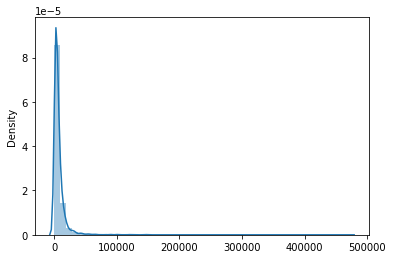

In [ ]:
doc_lengths = []

for sentences in texts_sentences:

    # get rough token count distribution
    tokens = nltk.word_tokenize('. '.join(sentences))

    doc_lengths.append(len(tokens))

doc_lengths_ = np.array(doc_lengths)

sns.distplot(doc_lengths_)

Il semble déjà que certains documents sont beaucoup trop longs. On les retire. 

In [ ]:
too_big_index = []
doc_lengths_ = []
for k in range(len(doc_lengths)): 
  if doc_lengths[k] >= 20000:
    too_big_index.append(k)
  else : 
    doc_lengths_.append(doc_lengths[k])
print(too_big_index)

[44, 55, 63, 108, 134, 158, 225, 232, 241, 261, 277, 319, 331, 334, 341, 342, 362, 369, 401, 459, 465, 473, 482, 489, 509, 529, 555, 570, 574, 582, 593, 620, 630, 640, 647, 657, 659, 699, 723, 763, 769, 773, 786, 801, 817, 821, 823, 839, 846, 861, 895, 923, 943, 963, 975, 1014, 1017, 1021, 1026, 1028, 1050, 1064, 1071, 1100, 1125, 1145, 1146, 1148, 1159, 1191, 1212, 1246, 1250, 1279, 1280, 1326, 1334, 1358, 1373, 1384, 1395, 1420, 1484, 1510, 1533, 1619, 1641, 1649, 1657, 1676, 1724, 1753, 1775, 1776, 1811, 1846, 1850, 1890, 1904, 2027, 2031, 2041, 2044, 2053, 2064, 2081, 2139, 2158, 2163, 2172, 2197, 2222, 2228, 2236, 2240, 2246, 2256, 2261, 2263, 2286, 2288, 2294, 2303, 2309, 2310, 2323, 2326, 2409, 2413, 2440, 2453, 2470, 2490, 2496, 2508, 2514, 2518, 2560, 2576, 2589, 2599, 2634, 2713, 2715, 2721, 2735, 2748, 2874, 2946, 2950, 2961, 2963, 2980, 3015, 3026, 3076, 3081, 3092, 3107, 3108, 3111, 3143, 3144, 3173, 3175, 3177, 3181, 3262, 3293, 3308, 3348, 3368, 3380, 3432, 3447, 3482, 3

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


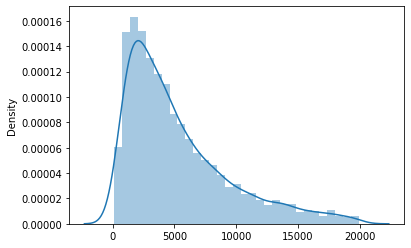

In [ ]:
sns.distplot(doc_lengths_)

Même après avoir enlevé ces éléments clairement trop longs, on remarque que le nombre de tokens des documents est en moyenne de 5000, ce qui est trop pour les Transformers usuels tels que BERT ou GPT2. Un pré-traitement s'impose donc pour réduire au maximum la taille des documents. On souhaite extraire les informations importantes à l'aide d'une méthode extractive.

**1. Méthode extractive**



On commence par créer une fonction qui ramène chaque mot d'un texte à sa forme la plus simple, pour ensuite utiliser l'embedding Glove. 

In [ ]:
def lemmatize(text: str, sp: sp.lang, disable=['tagger']) -> str:
    """
    renvoie 'text' lemmatizé
    """
    return ' '.join([tok.lemma_ for tok in sp(text, disable=disable)])


def semantic_repr_text(text: str, sp: sp.lang) -> (np.ndarray, list):
    """
    renvoie la représentation vectorielle de 'text pour l'analyse sémantique et
    les mots de 'text' à retirer de l'analyse
    """
    lem = sp(lemmatize(text.lower().replace('-', ' '), sp))
    tokens = [token for token in lem if dict_pos_weight[token.pos_]]
    if len(tokens) > 0:
        semantic_repr = sum([token.vector for token in tokens])/len(tokens)
        return semantic_repr/(np.sqrt(np.sum(semantic_repr**2))+1e-9)
    else:
        return np.zeros(300)

# Ce dictionnaire indique les types de mots à conserver dans l'analyse
dict_pos_weight = {}
dict_pos_weight['ADV'] = 0.
dict_pos_weight['VERB'] = 1.
dict_pos_weight['NOUN'] = 1.
dict_pos_weight['ADJ'] = 1.
dict_pos_weight['PRON'] = 0.
dict_pos_weight['AUX'] = 0.
dict_pos_weight['SCONJ'] = 0.
dict_pos_weight['PROPN'] = 1.
dict_pos_weight['ADP'] = 0.
dict_pos_weight['DET'] = 0.
dict_pos_weight['CCONJ'] = 0.
dict_pos_weight['INTJ'] = 0.
dict_pos_weight['NUM'] = 1.
dict_pos_weight['PART'] = 0.
dict_pos_weight['PUNCT'] = 0.
dict_pos_weight['SYM'] = 0.
dict_pos_weight['X'] = 0.
dict_pos_weight['SPACE'] = 0

disable = ['parser', 'tokenizer', 'ner', 'textcat']
sp_en = en_core_web_md.load(disable=disable)

In [ ]:
lemmatize('The owners of the computers are using the table', sp_en)

'The owner of the computer be use the table'

On regarde combien de mots font les phrases de notre jeu de données en moyenne. 

In [ ]:
n_sentences_tot = 0
n_words_tot = 0 
for sentences in (texts_sentences): 
  for sentence in sentences : 
    n_sentences_tot += 1
    tokens = nltk.word_tokenize(sentence)
    n_words_tot += len(tokens)
print(n_words_tot/n_sentences_tot)

33.658622010944406


On a environ 30 mots par phrase en moyenne : on peut représenter chaque texte par 5 phrases sans craindre de dépasser les max_length des modèles utilisés plus bas. Pour cela on réalise un kmeans à 5 centroïdes dans l'espace latent de Glove, puis on récupère les phrases les plus proches de chaque centroïde. 

In [ ]:
texts_sentences = np.array(texts_sentences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


L'embedding prend beaucoup de temps, on ne regarde que les 100 premiers textes sur 3000 pour commencer.

In [ ]:
texts_sentences_ = np.array(texts_sentences[0:100])

In [ ]:

repr_text_sentences = []
for sentences in tqdm(texts_sentences_): 
  sem_repr_sents = np.zeros((len(sentences), 300))
  for k, sentence in enumerate(sentences):
      sem_repr_sents[k] = semantic_repr_text(sentence, sp_en)
  repr_text_sentences.append(sem_repr_sents)













  0%|          | 0/100 [00:00<?, ?it/s]










  1%|          | 1/100 [00:34<56:44, 34.39s/it]










  2%|▏         | 2/100 [00:54<48:59, 29.99s/it]










  3%|▎         | 3/100 [01:09<41:33, 25.70s/it]










  4%|▍         | 4/100 [01:32<39:49, 24.89s/it]










  5%|▌         | 5/100 [01:56<38:42, 24.45s/it]










  6%|▌         | 6/100 [02:28<42:08, 26.90s/it]










  7%|▋         | 7/100 [02:41<35:16, 22.76s/it]










  8%|▊         | 8/100 [03:27<45:22, 29.60s/it]










  9%|▉         | 9/100 [03:47<40:42, 26.85s/it]










 10%|█         | 10/100 [04:02<34:31, 23.02s/it]










 11%|█         | 11/100 [06:03<1:18:00, 52.59s/it]










 12%|█▏        | 12/100 [07:01<1:19:26, 54.17s/it]










 13%|█▎        | 13/100 [07:17<1:02:01, 42.78s/it]










 14%|█▍        | 14/100 [07:29<47:48, 33.35s/it]  










 15%|█▌        | 15/100 [08:01<46:45, 33.00s/it]










 16%|█▌        | 16/100 [08:02<33:00, 23.57s/it]








On réalise maintenant un clustering à 5 centroïdes. L'idée est d'extraire 5 phrases représentant chaque document. 

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

all_centroids = []
for sem_repr_sents in tqdm(repr_text_sentences): 
  kmeans = KMeans(n_clusters=5).fit(sem_repr_sents)
  centroids = kmeans.cluster_centers_
  all_centroids.append(centroids)












  0%|          | 0/100 [00:00<?, ?it/s]










  1%|          | 1/100 [00:00<00:14,  6.79it/s]










  2%|▏         | 2/100 [00:00<00:13,  7.48it/s]










  4%|▍         | 4/100 [00:00<00:11,  8.16it/s]










  5%|▌         | 5/100 [00:00<00:11,  8.34it/s]










  6%|▌         | 6/100 [00:00<00:11,  8.01it/s]










  8%|▊         | 8/100 [00:00<00:11,  7.88it/s]










  9%|▉         | 9/100 [00:01<00:11,  8.20it/s]










 11%|█         | 11/100 [00:01<00:13,  6.44it/s]










 12%|█▏        | 12/100 [00:01<00:14,  6.24it/s]










 14%|█▍        | 14/100 [00:01<00:11,  7.43it/s]










 15%|█▌        | 15/100 [00:02<00:11,  7.24it/s]










 17%|█▋        | 17/100 [00:02<00:09,  8.68it/s]










 19%|█▉        | 19/100 [00:02<00:08,  9.32it/s]










 21%|██        | 21/100 [00:02<00:08,  9.47it/s]










 23%|██▎       | 23/100 [00:02<00:09,  7.92it/s]










 25%|██▌       | 25/100 [00:02<00:08,  9.20it/s]










 2

On peut maintenant récupérer les phrases les plus proches de chaque centroïde. 

In [ ]:
all_centroids = np.array(all_centroids)
all_index_sentences = []
for k in range(len(all_centroids)): 
  scores = all_centroids[k].dot(repr_text_sentences[k].T)
  index_sentences = sorted(np.apply_along_axis(np.argmax, 1, scores))
  all_index_sentences.append(index_sentences)

In [ ]:
all_summaries = []
for k in range(len(texts_sentences_)):
  sentences = np.array(texts_sentences_[k])
  index_sentences = all_index_sentences[k]
  summary = '. '.join(sentences[index_sentences])
  all_summaries.append(summary)

Voici un exemple de ce que l'on obtient. 

In [ ]:
all_summaries[50]

'The orders were made on 27 February 2006 ( Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) [2006] ATPR 42-103 , [2006] FCA 146 ; Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) (No 2) [2006] ATPR 42-104 , [2006] FCA 157).. There is a complication in that the third and fourth respondents are each bankrupt.. I have read the report that she prepared in this matter and I am satisfied that it reveals, first, a sound methodology for assessing the costs which would be taxable against the respondents and, second, that the methodology has been applied to the particular circumstances in an appropriate fashion.. If this occasions any difficulty, or if there is any need for any further order, I will grant special liberty to apply to the trustees of the bankrupt estates of the third and fourth respondents.. 9 For those reasons, I make orders (1) to (3) in the proposed orders which I have initialled and 

The orders were made on 27 February 2006 ( Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) [2006] ATPR 42-103 , [2006] FCA 146 ; Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) (No 2) [2006] ATPR 42-104 , [2006] FCA 157).. There is a complication in that the third and fourth respondents are each bankrupt.. I have read the report that she prepared in this matter and I am satisfied that it reveals, first, a sound methodology for assessing the costs which would be taxable against the respondents and, second, that the methodology has been applied to the particular circumstances in an appropriate fashion.. If this occasions any difficulty, or if there is any need for any further order, I will grant special liberty to apply to the trustees of the bankrupt estates of the third and fourth respondents.. 9 For those reasons, I make orders (1) to (3) in the proposed orders which I have initialled and there will be a further order (4): (4) Special liberty is reserved to the trustees in bankruptcy of the third and fourth respondents respectively to apply.

In [ ]:
'. '.join(texts_sentences_[50])

" 1 This is an application pursuant to O 62 r 4(2)(c) of the Federal Court Rules that certain costs ordered to be payable by the respondents in this matter be assessed as a gross sum.. The orders were made on 27 February 2006 ( Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) [2006] ATPR 42-103 , [2006] FCA 146 ; Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) (No 2) [2006] ATPR 42-104 , [2006] FCA 157).. Order 42 provided that the third, fourth, fifth, sixth and seventh respondents pay the applicant's costs of the proceedings including all reserved costs, except those costs provided by order 43.. Order 43 provided that the third and fourth respondents pay the applicant's costs of the hearing on 10, 25 and 26 May 2005.. 2 There were some formalities to be proved in relation to service.. I have read the affidavits provided in relation to service and I am satisfied that each of the relevant res

Certaines phrases du résumé restent très longues, mais le résumé semble efficace d'un point de vue qualitatif, et le texte est très grandement raccourci. Les résumés ainsi traités sont encore trop longs, mais sont désormais assez courts pour être traités par un Transformer pré-entraîné. 

 **2. BART**

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

In [ ]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
#Modèle pré-entraîné pour le résumé de texte
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

In [ ]:
all_BART_summaries = []
for summary in tqdm(all_summaries) : 
  input_ids = tokenizer.encode(summary, return_tensors="pt")
  generated_seq = model.generate(input_ids=input_ids, max_length=200, min_length=10, top_p=0.95, temperature=0.7)
  all_BART_summaries.append(generated_seq)












  0%|          | 0/100 [00:00<?, ?it/s]










  1%|          | 1/100 [00:10<17:41, 10.72s/it]










  2%|▏         | 2/100 [00:21<17:38, 10.80s/it]










  3%|▎         | 3/100 [00:32<17:26, 10.78s/it]










  4%|▍         | 4/100 [00:43<17:08, 10.71s/it]










  5%|▌         | 5/100 [00:53<16:50, 10.64s/it]










  6%|▌         | 6/100 [01:03<16:36, 10.60s/it]










  7%|▋         | 7/100 [01:14<16:34, 10.70s/it]










  8%|▊         | 8/100 [01:26<16:36, 10.83s/it]










  9%|▉         | 9/100 [01:36<16:22, 10.79s/it]










 10%|█         | 10/100 [01:47<16:04, 10.72s/it]










 11%|█         | 11/100 [01:58<15:57, 10.76s/it]










 12%|█▏        | 12/100 [02:08<15:43, 10.72s/it]










 13%|█▎        | 13/100 [02:19<15:26, 10.65s/it]










 14%|█▍        | 14/100 [02:29<15:14, 10.64s/it]










 15%|█▌        | 15/100 [02:40<15:00, 10.59s/it]










 16%|█▌        | 16/100 [02:47<13:10,  9.41s/it]










 17%

In [ ]:
generated_seq = all_BART_summaries[50]
print("Number of tokens:", len(generated_seq.squeeze()))
tokenizer.decode(generated_seq.squeeze(), skip_special_tokens=True)


Number of tokens: 200


'The orders were made on 27 February 2006 ( Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) (No 2) [2006] ATPR 42-103, [2006][FCA 157).. The order was made on 26 February 2006.. The orders are made on the basis of the following: The orders have been made on 28 February 2006 and the orders are: (1) There is a complication in that the third and fourth respondents are each bankrupt.. I have read the report that she prepared in this matter and I am satisfied that it reveals, first, a sound methodology for assessing the costs which would be taxable against the respondents and, second, that the methodology has been applied to the particular circumstances in an appropriate fashion.. If this occasions any difficulty, or if there is any need for any further order, I will grant special liberty to apply to the trustees of the bankrupt estates of the third, fourth respondents.. 9 For those reasons,'

The orders were made on 27 February 2006 ( Australian Competition and Consumer Commission v Global Prepaid Communications Pty Ltd (in liq) (No 2) [2006] ATPR 42-103, [2006][FCA 157).. The order was made on 26 February 2006.. The orders are made on the basis of the following: The orders have been made on 28 February 2006 and the orders are: (1) There is a complication in that the third and fourth respondents are each bankrupt.. I have read the report that she prepared in this matter and I am satisfied that it reveals, first, a sound methodology for assessing the costs which would be taxable against the respondents and, second, that the methodology has been applied to the particular circumstances in an appropriate fashion.. If this occasions any difficulty, or if there is any need for any further order, I will grant special liberty to apply to the trustees of the bankrupt estates of the third, fourth respondents.. 

**Evaluation**

Pour évaluer nos résumés on utilise la métrique ROUGE-1. 'p' est l'abréviation de précision, et indique la proportion de mots dans le résumé généré qui sont aussi dans le résumé de référence. 'r' est le rappel, qui mesure le rappel qui, au contraire, mesure la proportion de mots dans le résumé de référence qui sont aussi dans le résumé généré. 

'f' est le f1 score, défini par : 

$$F = \frac{2RP}{R + 4P}$$

La métrique rouge-2 calcule le nombre de séquences de deux mots en commun, mais n'est pas pertinente ici car nos résumés de référence ne forment pas des phrases correctes mais plutôt des groupes nominaux contenant des mots clés. 

On évalue d'abord le résumé extractif

In [306]:
texts_catchphrases_ = texts_catchphrases[0:100]
all_catchphrases = []
for catchphrases in texts_catchphrases_: 
  all_catchphrases.append('. '.join(catchphrases))

Rouge().get_scores(all_summaries, all_catchphrases, avg = True)

{'rouge-1': {'f': 0.16261660996374797,
  'p': 0.11035339525224326,
  'r': 0.42397283361547544},
 'rouge-2': {'f': 0.03827499471358228,
  'p': 0.025827862980456095,
  'r': 0.1013637299815713},
 'rouge-l': {'f': 0.1525751452262193,
  'p': 0.10268373205513308,
  'r': 0.36393329552760273}}

On obtient un rappel important (0.42), ce qui signifie que notre résumé contient une bonne partie des mots-clés présents dans le standard. En revanche, la précision est faible, ce qui suggère que notre résumé est peut-être trop long. Cela vient aussi du fait que les résumés standards sont écrits en abrégés, et ne sont constitués quasiment que de mots clés, et qu'on les compare à des phrases complètes. 

Les résultats de rouge-2 sont très faibles, on pouvait s'y attendre vu la façon dont les résumés standard sont écrits : ils ne sont constitués que de mots-clés, donc les groupes de deux mots adjacents n'ont pas réellement de signification. 


In [307]:
all_BART_summaries_decoded = []
for k in range(len(all_BART_summaries)):   
  decoded = tokenizer.decode(np.array(all_BART_summaries[k]).squeeze(), skip_special_tokens=True)
  all_BART_summaries_decoded.append(decoded)

In [308]:
Rouge().get_scores(all_BART_summaries_decoded, all_catchphrases[0:100], avg = True)

{'rouge-1': {'f': 0.17614356418520485,
  'p': 0.13678375156839195,
  'r': 0.3466483962868492},
 'rouge-2': {'f': 0.03540640124612113,
  'p': 0.027566910836292462,
  'r': 0.07140635018468493},
 'rouge-l': {'f': 0.15336649204769753,
  'p': 0.11328865151185079,
  'r': 0.30049659946490026}}

Avec le transformer, la précision moyenne augmente et le rappel diminue. Cela est du au fait que le résumé précédent, déjà concis, est encore un peu raccourci. Les résultats restent peu significatifs. 

Bien que cet essai soit relativement concluant, puisqu'il prouve que nous avons pu conserver une bonne partie des mots-clés dans un résumé de 200 mots, sur parfois plusieurs dizaines de milliers, on souhaite valider le modèle en le testant sur les documents les plus courts. 

In [339]:
short_articles = []
short_catchphrases = []
for k in range(len(texts_sentences)): 

    if doc_lengths[k]< 1000 and doc_lengths[k] > 400: 

      short_articles.append(texts_sentences[k])
      short_catchphrases.append(texts_catchphrases[k])

len(short_articles)

240

In [340]:
short_articles = np.array(short_articles)
repr_text_sentences = []
for sentences in tqdm(short_articles): 
  sem_repr_sents = np.zeros((len(sentences), 300))
  for k, sentence in enumerate(sentences):
      sem_repr_sents[k] = semantic_repr_text(sentence, sp_en)
  repr_text_sentences.append(sem_repr_sents)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.











  0%|          | 0/240 [00:00<?, ?it/s]










  0%|          | 1/240 [00:05<23:24,  5.88s/it]










  1%|          | 2/240 [00:09<20:57,  5.29s/it]










  1%|▏         | 3/240 [00:12<17:53,  4.53s/it]










  2%|▏         | 4/240 [00:16<16:52,  4.29s/it]










  2%|▏         | 5/240 [00:19<15:34,  3.98s/it]










  2%|▎         | 6/240 [00:23<15:43,  4.03s/it]










  3%|▎         | 7/240 [00:25<13:13,  3.41s/it]










  3%|▎         | 8/240 [00:29<13:17,  3.44s/it]










  4%|▍         | 9/240 [00:32<12:52,  3.35s/it]










  4%|▍         | 10/240 [00:35<12:12, 

In [357]:
from sklearn.cluster import KMeans
import numpy as np

all_centroids = []
for sem_repr_sents in tqdm(repr_text_sentences): 
  kmeans = KMeans(n_clusters=4).fit(sem_repr_sents)
  centroids = kmeans.cluster_centers_
  all_centroids.append(centroids)

all_centroids = np.array(all_centroids)
all_index_sentences = []
for k in range(len(all_centroids)): 
  scores = all_centroids[k].dot(repr_text_sentences[k].T)
  index_sentences = sorted(np.apply_along_axis(np.argmax, 1, scores))
  all_index_sentences.append(index_sentences)
all_summaries = []
for k in range(len(short_articles)):
  sentences = np.array(short_articles[k])
  index_sentences = all_index_sentences[k]
  summary = '. '.join(sentences[index_sentences])
  all_summaries.append(summary)












  0%|          | 0/240 [00:00<?, ?it/s]










  1%|          | 2/240 [00:00<00:13, 18.24it/s]










  2%|▏         | 5/240 [00:00<00:11, 20.13it/s]










  4%|▍         | 9/240 [00:00<00:09, 23.12it/s]










  5%|▌         | 12/240 [00:00<00:09, 24.75it/s]










  7%|▋         | 16/240 [00:00<00:08, 26.82it/s]










  8%|▊         | 19/240 [00:00<00:08, 27.52it/s]










 10%|▉         | 23/240 [00:00<00:07, 28.73it/s]










 11%|█         | 26/240 [00:00<00:08, 26.06it/s]










 12%|█▏        | 29/240 [00:01<00:08, 24.38it/s]










 13%|█▎        | 32/240 [00:01<00:09, 23.10it/s]










 15%|█▍        | 35/240 [00:01<00:08, 23.39it/s]










 16%|█▌        | 38/240 [00:01<00:08, 24.98it/s]










 17%|█▋        | 41/240 [00:01<00:07, 25.50it/s]










 18%|█▊        | 44/240 [00:01<00:07, 24.50it/s]










 20%|█▉        | 47/240 [00:01<00:07, 24.16it/s]










 21%|██        | 50/240 [00:01<00:07, 24.83it/s]










In [358]:
all_BART_summaries = []
for summary in tqdm(all_summaries) : 
  input_ids = tokenizer.encode(summary, return_tensors="pt")
  generated_seq = model.generate(input_ids=input_ids, max_length=200, min_length=10, top_p=0.95, temperature=0.7)
  all_BART_summaries.append(generated_seq)












  0%|          | 0/240 [00:00<?, ?it/s]










  0%|          | 1/240 [00:06<27:31,  6.91s/it]










  1%|          | 2/240 [00:17<31:29,  7.94s/it]










  1%|▏         | 3/240 [00:28<35:10,  8.91s/it]










  2%|▏         | 4/240 [00:35<32:29,  8.26s/it]










  2%|▏         | 5/240 [00:45<35:19,  9.02s/it]










  2%|▎         | 6/240 [00:56<37:01,  9.49s/it]










  3%|▎         | 7/240 [01:03<34:06,  8.78s/it]










  3%|▎         | 8/240 [01:10<32:13,  8.33s/it]










  4%|▍         | 9/240 [01:22<35:33,  9.24s/it]










  4%|▍         | 10/240 [01:28<32:19,  8.43s/it]










  5%|▍         | 11/240 [01:39<34:47,  9.11s/it]










  5%|▌         | 12/240 [01:46<31:54,  8.40s/it]










  5%|▌         | 13/240 [01:57<34:24,  9.09s/it]










  6%|▌         | 14/240 [02:07<36:18,  9.64s/it]










  6%|▋         | 15/240 [02:17<36:08,  9.64s/it]










  7%|▋         | 16/240 [02:26<35:43,  9.57s/it]










  7%

IndexError: ignored

In [360]:
short_catchphrases_text= []
for k in range(len(all_summaries)): 
  seq = '. '.join(short_catchphrases[k])
  short_catchphrases_text.append(seq)
Rouge().get_scores(all_summaries, short_catchphrases_text, avg = True)

{'rouge-1': {'f': 0.1284575910410241,
  'p': 0.08391778952130771,
  'r': 0.4095013573763155},
 'rouge-2': {'f': 0.03355941979495878,
  'p': 0.021905084544544682,
  'r': 0.10848904191916979},
 'rouge-l': {'f': 0.13305983638797,
  'p': 0.08732332793803725,
  'r': 0.3730045391512889}}

On obtient peu ou prou les mêmes résultats que sur tout le dataset.